# 2. Clustering

**Pre-considerations**

The dataset we focus on describes Amazon food products and each line corresponds to a review. The goal is to be able to cluster the products contained in the dataset (about 74k) in the most efficient way possible

### Useful libraries

In [1]:
import pandas as pd
#import plotly
import numpy as np
import matplotlib.pyplot  as plt
#import plotly.graph_objects as go
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix
from scipy.sparse import csr_matrix


from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import spacy
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Starting with uploading the dataset

In [ ]:
dataset = pd.read_csv("Reviews.csv",encoding='utf-8')

## Data cleaning
Let's clean the dataset deleting the missing values

In [ ]:
dataset.isnull().sum()
dataset['ProfileName'].fillna('',inplace = True)
dataset['Summary'].fillna('',inplace = True)
dataset.head()

In [ ]:
# We introduce a new column with the conversion of every value in Timestamp

dataset['Datetime']=dataset.Time.apply(lambda value:pd.to_datetime(value,unit='s'))

Let's clean the dataset from the useless words using nlkt toolkit

In [ ]:
lemmatizer = PorterStemmer()
stop_words = set(stopwords.words('english'))
e_words = set(nltk.corpus.words.words())

In [ ]:
def clean_text(text):
    
    
    words = word_tokenize(text)
    good_words = []
    for word in words:
        if word.lower() not in stop_words and word.isalpha() and word.lower() in e_words:
            good_words.append(word.lower())
    return good_words

After defining a function to clean the text (removing stopword,tokenize the sentences and apply the stemmatization according to the PorterStemmer),
we use it on all the items belonging to the Summary column and then we create a new column named **subject_words** in which we add the processed texts.

In [ ]:
word_list = dataset['Text'].apply(lambda text: clean_text(text))
dataset['subject_words']=word_list

# Let's take a sub-dataset more useful for our purpose
df1 = dataset[['Id','ProductId','UserId','Score','subject_words']]

# -------------------------------------


After that we have cleaned the words in the plots, let's save a new dataset adding the column **subject_words** as "df_finale.json".

Now we import directly it

In [2]:
df1 = pd.read_json('df_finale.json', encoding='utf-8', lines=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Id             568454 non-null  int64 
 1   ProductId      568454 non-null  object
 2   UserId         568454 non-null  object
 3   Score          568454 non-null  int64 
 4   subject_words  568454 non-null  object
dtypes: int64(2), object(3)
memory usage: 21.7+ MB


In order to reduce our dataset, we don't considere multiple reviews for the same ProductId, but we take just one for each product

In [3]:
# this is the dataset that contain all the products with only one description

df2 = df1.drop_duplicates(subset='ProductId', keep="last")

print(len(df2))

74258


### Data Cleanint pt.2

Let's continue the cleaning of our dataset, removing from "subject_words" all the words that are not names and the general word that are not meaningful for our purpose

In [12]:
nlp = spacy.load('en_core_web_sm')

C:\Users\thoma\Anaconda64\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
tot_nouns = []
list_descr = df1['subject_words'].tolist()

for desc in list_descr:
    desc = " ".join(desc)
    
    doc = nlp(desc)
    nouns = []
    for token in doc:
        if token.pos_ == 'NOUN':
            nouns.append(token)
    tot_nouns.append(nouns)

In [4]:
df_n = pd.read_csv("dataset_nomi2.csv",encoding='utf-8')

In [ ]:
df_n.head()

Now, we have in the column 'names' the result of subject_words's filtering by only the words that are **NAMES**

In [9]:
df2['names'] = df_n['tot_nouns']

<ipython-input-9-53f4f244583e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['names'] = df_n['tot_nouns']


In [10]:
df2.head()

,Id,ProductId,UserId,Score,subject_words,names
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,"[bought, several, vitality, canned, dog, food,...","[vitality, dog, food, quality, product, meat, ..."
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,"[product, jumbo, salted, actually, small, size...","[product, jumbo, error, vendor, product, jumbo]"
2,3,B000LQOCH0,ABXLMWJIXXAIN,4,"[confection, around, light, pillowy, citrus, g...","[confection, pillowy, case, sugar, chewy, trea..."
3,4,B000UA0QIQ,A395BORC6FGVXV,2,"[looking, secret, ingredient, believe, found, ...","[ingredient, believe, addition, root, beer, ex..."
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,5,"[taffy, good, soft, chewy, amazing, would, def...",[chewy]


---------------------------------------------------

As we can see from the **analysis of frequent words**, there are a lot of word with general meaning that could affect in a negative way our Clustering. We decided to avoid these word in order to creare relationship among words more sectorial and with more powerful meaning 

In [11]:
freq = pd.Series(df2['names']).value_counts()[:20]
freq

[]                           582
[product]                    102
[taste]                       72
[flavor]                      50
[price]                       42
[love]                        36
[coffee]                      31
[product, order]              28
[gift]                        23
[chocolate]                   23
[sugar]                       23
[buy]                         23
[tea]                         22
[time]                        22
[order]                       22
[store]                       21
[quality]                     21
[item]                        20
[ship, bone, dogs, snack]     20
[stuff]                       20
Name: names, dtype: int64

In [2]:
genelar_words = ["product","taste","price","love","order", "product, order" , "buy", "store" ,"quality"]


In [31]:
m_names = []
list_names = df2['names'].tolist()

for desc in list_names:
    desc = "".join(desc)
    desc= desc.replace("[", "")
    desc= desc.replace("]", "")
    desc = list(desc.split(',')) 
    
    m_nouns = []
    for token in desc:
        token = token.strip()
        
        if token not in genelar_words : 
            m_nouns.append(token)
    m_names.append(m_nouns)

In [36]:
df2["meaningful_names"] = m_names


<ipython-input-36-cdd85cbce815>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["meaningful_names"] = m_names


### Data Cleaning conclusion

Now let's select our final dataset, with the useful columns and cointaining only the words that can be meaningful (meaningful_names) for the clustering of products

In [37]:
df3 = df2[['Id','ProductId','UserId','Score','meaningful_names']]
df3.head()

,Id,ProductId,UserId,Score,meaningful_names
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,"[vitality, dog, food, meat]"
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,"[jumbo, error, vendor, jumbo]"
2,3,B000LQOCH0,ABXLMWJIXXAIN,4,"[confection, pillowy, case, sugar, chewy, trea..."
3,4,B000UA0QIQ,A395BORC6FGVXV,2,"[ingredient, believe, addition, root, beer, ex..."
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,5,[chewy]


In [ ]:
df3.to_csv('clean_df.csv', encoding='utf-8', index=False)


In [4]:
df3 = pd.read_csv("clean_df.csv",encoding='utf-8')

## Data Pre-processing

Now that we have a complete and cleaned dataset, We choose to map each word in *meaningful_names* with tdidf score.

We prefer to use tdidf representation because we thinks that it is less time consuming and has less computational cost, respect to binary research.

In [38]:
meaningful_names = df3['meaningful_names'].tolist()

In [39]:
#Let's create a corpus that cointains all the reviews, and for each review there are the most significant names

corpus = []
for i in range(0,len(meaningful_names)):
    res = "".join(str(meaningful_names[i]))
    res = list(res)
    res.pop(0)
    res.pop(-1)
    res = "".join(res)
    corpus.append(res)

# for each word in the descriptions we calculate it's tfidf and save it in a matrix "tdIdf"
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(corpus)


In [40]:
#Let's take the name of all the words
features_names = tfIdfVectorizer.get_feature_names()


## SVD Method

### Let's reduce the dimensionality of our tfidf object

There are too many features and these sparse data can be reduced working on the dimensionality. We need to find the number of components that retain at least 60% of sample's variance. Therefore we decided to use the *Truncated SVD Method*

In [42]:
svd = TruncatedSVD(n_components=635, n_iter=7, random_state=42)

In [43]:
svd.fit(tfIdf)

TruncatedSVD(n_components=635, n_iter=7, random_state=42)

In [45]:
np.cumsum(svd.explained_variance_ratio_)

array([0.01482009, 0.02930965, 0.0390502 , 0.04895634, 0.05773857,
       0.06499692, 0.07103842, 0.07678164, 0.08244213, 0.08774772,
       0.09283934, 0.09782352, 0.10262338, 0.1073804 , 0.11201431,
       0.11652995, 0.12082851, 0.12505533, 0.12919408, 0.13324138,
       0.13721233, 0.14103924, 0.14482246, 0.14858247, 0.15220347,
       0.15577656, 0.15931726, 0.16282921, 0.16630978, 0.16975209,
       0.17316382, 0.17653111, 0.17987121, 0.18316289, 0.18638764,
       0.18953907, 0.19266204, 0.19575717, 0.1988223 , 0.20183427,
       0.20483523, 0.20780037, 0.21075432, 0.21363981, 0.2164568 ,
       0.21922008, 0.22195991, 0.22467436, 0.22733152, 0.22995618,
       0.23257516, 0.23515749, 0.2377293 , 0.24027765, 0.24281586,
       0.24533348, 0.24781373, 0.25029258, 0.25272513, 0.25512923,
       0.25752162, 0.25987094, 0.26221397, 0.26452881, 0.26683198,
       0.26910648, 0.27136136, 0.27358533, 0.27578323, 0.27797751,
       0.28011725, 0.28223041, 0.28431939, 0.28636634, 0.28839

After different tests, we choose a set of 635 elements which represent the 70% of the dataset's variance. 

This is an acceptable value for our purpose.

In [46]:
reduced_tfIdf = svd.transform(tfIdf)

In [47]:
# We consider the same random seed of SVD method in order to recover the name of the right words choosen by svd

np.random.seed(42)
features_names_samples = random.sample(features_names, k=635)
features_names_samples = sorted(features_names_samples)
print(features_names_samples[0:5])

['abiding', 'accuracy', 'acetone', 'acid', 'acquaintance']


In [48]:
# Now let's create the matrix that has words as features and tfidf score as values for each product.

B = csr_matrix(reduced_tfIdf)
B = B.todense()

dfA = pd.DataFrame(B, columns = features_names_samples)
dfA.head()

,abiding,accuracy,acetone,acid,acquaintance,active,adapt,add,adhesion,admission,...,whomever,whopping,wipe,worked,wreckage,writer,yappy,yawning,yep,yield
0,0.037864,0.050399,0.233601,-0.282406,-0.011720,-0.145170,0.054530,0.013459,0.032405,0.113633,...,0.002201,-0.002915,-0.003154,0.004899,-0.001686,0.001996,0.001869,-0.003277,0.002612,0.003713
1,0.002911,0.001866,0.004269,0.000051,0.001619,0.007463,-0.001611,0.005621,-0.000887,-0.000729,...,0.001280,0.011740,-0.000297,-0.001145,-0.002394,-0.016087,-0.006681,-0.002714,0.007729,0.006820
2,0.030722,0.024760,0.051588,0.007421,0.021024,0.024860,-0.089260,-0.042640,0.125484,0.059674,...,0.025876,-0.011319,0.016510,0.033312,-0.003301,-0.045265,-0.002249,-0.017059,-0.016325,-0.001922
3,0.058319,0.042012,0.069248,0.094948,-0.095651,-0.042763,0.009257,0.009061,0.025575,-0.002770,...,0.019976,-0.008732,-0.024212,-0.010793,-0.015467,-0.007182,-0.011253,-0.008195,0.027452,0.024765
4,0.005737,0.005828,0.015869,0.006735,0.002948,0.006455,-0.013242,0.012295,0.015973,0.004743,...,-0.003717,-0.005701,-0.006597,0.001512,0.001738,-0.003160,0.003096,-0.000548,-0.000675,0.002263


In [49]:
#Save the dataset to use when needed

dfA.to_csv('Words_df.csv', encoding='utf-8', index=False)

In [5]:
dfA = pd.read_csv("Words_df.csv",encoding='utf-8')

In [6]:
# 74258 Products
# 635 words

dfA.shape

(74258, 635)

# K means algorithm

Now it's the time to implement a K-means algorithm in order to cluster our ready dataset.

In [38]:
#First of all we define a general function to calculate the distance between two points
def compute_distance(a, b):
    distance = np.sqrt(sum((a-b)**2))
    return (distance)

#Let's assign for each data point the index of a centroid.
#N.B: an entire row of data in dataframe MEANS a data point
def nearest_centroids(centrs, x):
    assigned_centroid = []
    for i in x:
        distances=[]
        for j in centrs:
            distances.append(compute_distance(i,j))
        assigned_centroid.append(np.argmin(distances))
    return assigned_centroid

#Let's calculate the new centroinds considering the mean in the clusters
def compute_centroids(clusters, X):
    new_centroids = []
    new_df = pd.concat([pd.DataFrame(X), pd.DataFrame(clusters, columns=['cluster'])],axis=1)
    for c in set(new_df['cluster']):
        current_cluster = new_df[new_df['cluster'] == c][new_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    return new_centroids

**Launch the algo.**

The numbers of clusters comes out from the Elbow analysis, that is explained later

In [39]:
X = np.array(dfA)

init_centroids = random.sample(range(0, len(dfA)), 15) #let's define here the number of clusters (15)

#Let's take the values
centroids = []
for i in init_centroids:
    centroids.append(dfA.loc[i])
#centroids
centroids = np.array(centroids)

for i in range(30):
    get_centroids = nearest_centroids(centroids, X)
    centroids = compute_centroids(get_centroids, X)
    


In [40]:
# Let's add to our dataset a column with the results of k-means algorithm

labels = get_centroids
df3['cluster_kmeans'] = labels
df3.head()


,Id,ProductId,UserId,Score,meaningful_names,cluster_kmeans_plus,cluster_kmeans
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,"['vitality', 'dog', 'food', 'meat']",0,6
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,"['jumbo', 'error', 'vendor', 'jumbo']",12,13
2,3,B000LQOCH0,ABXLMWJIXXAIN,4,"['confection', 'pillowy', 'case', 'sugar', 'ch...",3,13
3,4,B000UA0QIQ,A395BORC6FGVXV,2,"['ingredient', 'believe', 'addition', 'root', ...",12,12
4,8,B006K2ZZ7K,A3JRGQVEQN31IQ,5,['chewy'],3,13


### Elbow method

Let's use the Elbow method to visualize the inertia of the model, according to different numbers of initialized clusters.
We will find the number of cluster that will fit better the dataset

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [59:41<00:00, 61.75s/it]


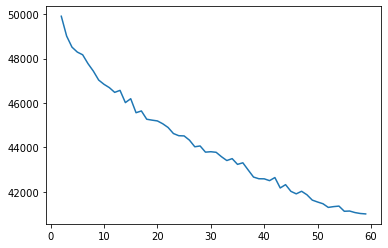

In [52]:
from tqdm import tqdm

elbow = {}
for k in tqdm(range(2, 60)):
    elbow_model = KMeans(n_clusters=k)
    elbow_model.fit_predict(dfA)
    elbow[k] = elbow_model.inertia_
    
plt.plot(list(elbow.keys()),list(elbow.values()));

We can see that the optimal numbers can be considered 15 or 12, before that the function start to converge.

After done different tests, we have choosen 15 as optimal number of clusters.

# ----------------------------------

# Comparision with the K-means ++

In [30]:
kmeans = KMeans(n_clusters = 15, init = 'k-means++')

In [31]:
X = np.array(dfA)
kmeans.fit(X)

KMeans(n_clusters=15)

In [32]:
kmeans.cluster_centers_

array([[ 4.83366407e-02,  5.10053169e-02,  1.93108162e-01, ...,
        -5.92926836e-05,  3.91370624e-04,  1.75693901e-04],
       [ 5.40937935e-02,  4.92018781e-02,  1.08718433e-01, ...,
         1.13408188e-04, -3.36952447e-04, -3.03631646e-05],
       [ 8.63156647e-02,  9.47312264e-02,  1.35713056e-01, ...,
         4.49125165e-05, -6.19492194e-05, -3.49156531e-04],
       ...,
       [ 4.25708172e-02,  3.00852675e-02,  5.56356776e-02, ...,
         2.33968505e-04, -1.25048359e-04, -8.75330530e-06],
       [ 5.44767323e-02,  3.47526336e-02,  5.99138146e-02, ...,
        -1.43992890e-04,  3.11956796e-04,  4.00497047e-05],
       [ 6.23418330e-02,  4.54880979e-02,  7.73431712e-02, ...,
        -3.04671013e-04, -1.46182800e-04,  9.47068507e-05]])

In [33]:
labels2 = kmeans.labels_

In [43]:
df3['cluster_kmeans_plus'] = labels2
df3.head()

,Id,ProductId,UserId,Score,meaningful_names,cluster_kmeans_plus,cluster_kmeans
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,"['vitality', 'dog', 'food', 'meat']",0,6
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,"['jumbo', 'error', 'vendor', 'jumbo']",12,13
2,3,B000LQOCH0,ABXLMWJIXXAIN,4,"['confection', 'pillowy', 'case', 'sugar', 'ch...",3,13
3,4,B000UA0QIQ,A395BORC6FGVXV,2,"['ingredient', 'believe', 'addition', 'root', ...",12,12
4,8,B006K2ZZ7K,A3JRGQVEQN31IQ,5,['chewy'],3,13


In [35]:
kmeans.n_iter_

32

In [49]:
df3.to_csv('df_with_all_clusters.csv', encoding='utf-8', index=False)

### Analyse the differences between K-means self implemented and K-means ++ (by Sklearn)
- World cloud

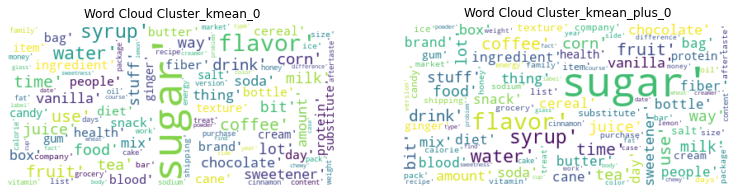

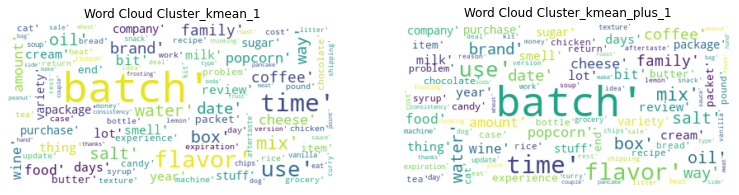

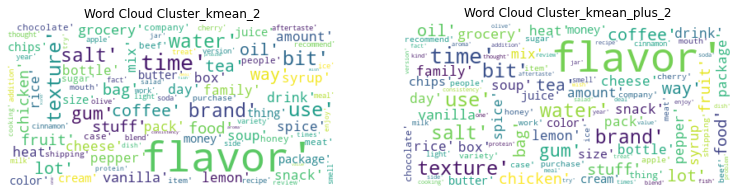

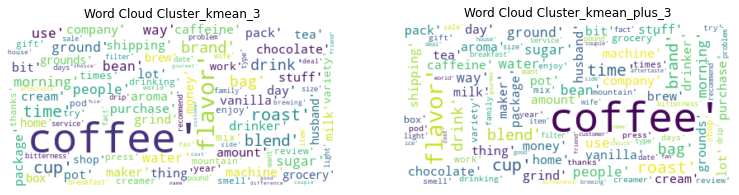

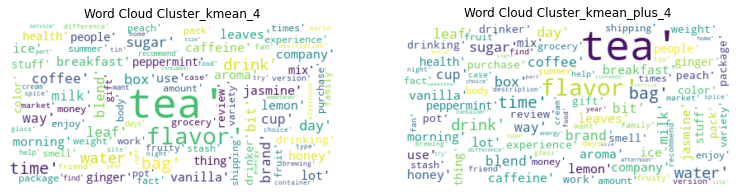

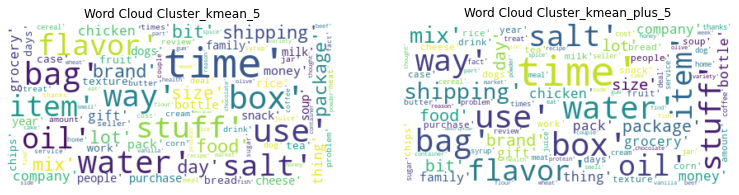

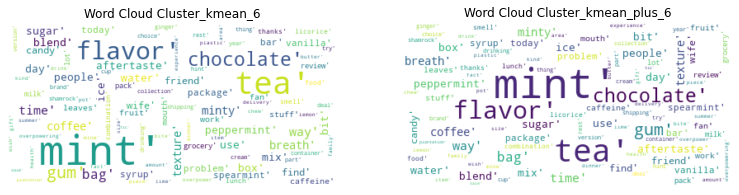

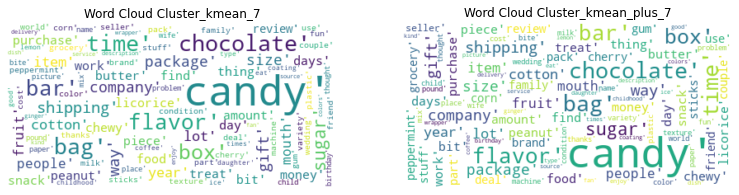

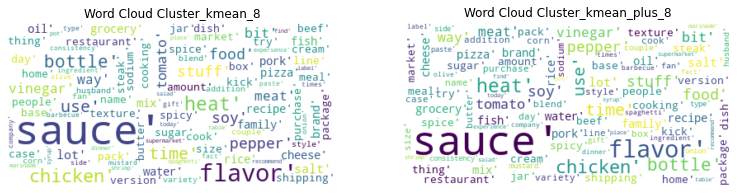

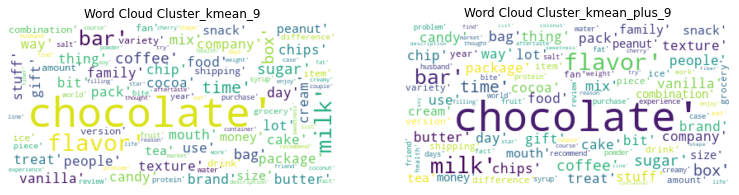

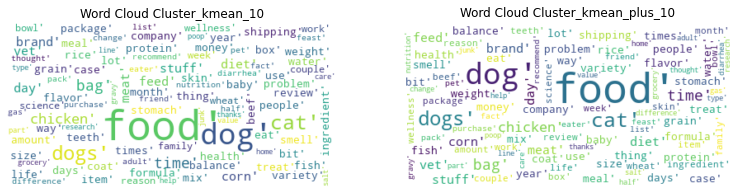

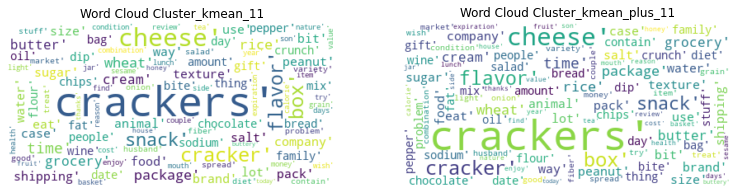

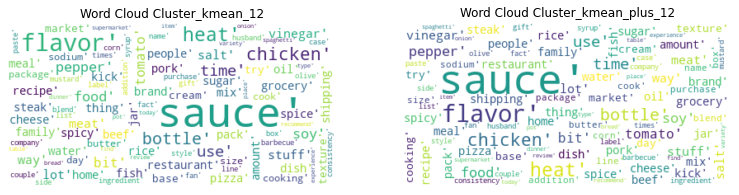

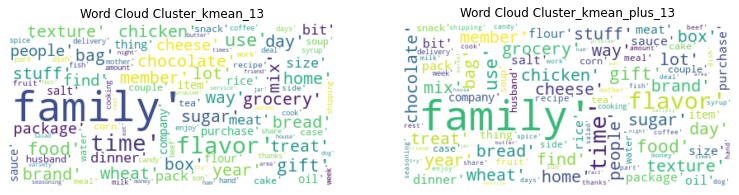

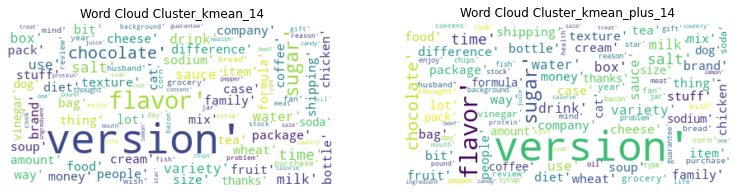

In [44]:

# Set the parameter
n_cluster = 15 # Optimal number of cluster find with the elbow method
font_size = 50
number_words = 100 # max number of words shown
mode = 'bilinear'

# Plot the bins and distribution for each cluster
for i in range(n_cluster):
    exec(f'cluster_kmean_{i} = " ".join(str(name) for name in df3[df3["cluster_kmeans"] == {i} ].meaningful_names)')
    exec(f'cluster_kmean_{i} = cluster_kmean_{i}.replace("[", "")')
    exec(f'cluster_kmean_{i} = cluster_kmean_{i}.replace("]", "")')
    exec(f'wordcloud_kmean_{i} = WordCloud(max_font_size=font_size, max_words=number_words, background_color="white", collocations=False).generate(cluster_{i})')
    
    exec(f'cluster_kmean_plus_{i} = " ".join(str(name) for name in df3[df3["cluster_kmeans_plus"] == {i} ].meaningful_names)')
    exec(f'cluster_kmean_plus_{i} = cluster_kmean_plus_{i}.replace("[", "")')
    exec(f'cluster_kmean_plus_{i} = cluster_kmean_plus_{i}.replace("]", "")')
    exec(f'wordcloud_kmean_plus_{i} = WordCloud(max_font_size=font_size, max_words=number_words, background_color="white", collocations=False).generate(cluster_{i})')
    
    fig, axes = plt.subplots(1, 2, figsize=(13,8))
    #fig.suptitle(f'Word')
    exec(f'axes[0].imshow(wordcloud_kmean_{i}, interpolation = mode)') 
    axes[0].set_title(f'Word Cloud Cluster_kmean_{i}')
    axes[0].axis("off")
    
      
    exec(f'axes[1].imshow(wordcloud_kmean_plus_{i}, interpolation = mode)')
    axes[1].set_title(f'Word Cloud Cluster_kmean_plus_{i}')
    axes[1].axis("off")
    
    plt.show()

As we can see from the clouds, in the major part of the clusters we can recognize,with an high accuracy, the category and the products inside. This means that our k-means model has a small difference with respect to k-means++ model in term of cluster's meaning. Even if our K-means model has an higher computability cost than to k-means++, we will find more or less to the same result. A possible explanation of our time complexity, is that we have decided to initialize our centroid's research selecting them at random.

- **Number of product in each cluster**

In [45]:
df3.groupby(df3.cluster_kmeans).cluster_kmeans.count()

cluster_kmeans
0       574
1      1316
2       972
3      2552
4       629
5       485
6      3994
7      1392
8      2185
9      3417
10      598
11     1647
12     5286
13    45103
14     4108
Name: cluster_kmeans, dtype: int64

In [46]:
df3.groupby(df3.cluster_kmeans_plus).cluster_kmeans_plus.count()

cluster_kmeans_plus
0      1883
1      1773
2      2495
3       407
4      1945
5       629
6      1582
7      4186
8      1144
9      2991
10     1416
11     3480
12    48299
13      513
14     1515
Name: cluster_kmeans_plus, dtype: int64

As we can expect there are differences in the number of items in each cluster. We can find one main reason about this result in the different centroids' initialization in the two algorithms.

- **Reviews' score distribution in each cluster. Test if their mean differences are statistically significant**

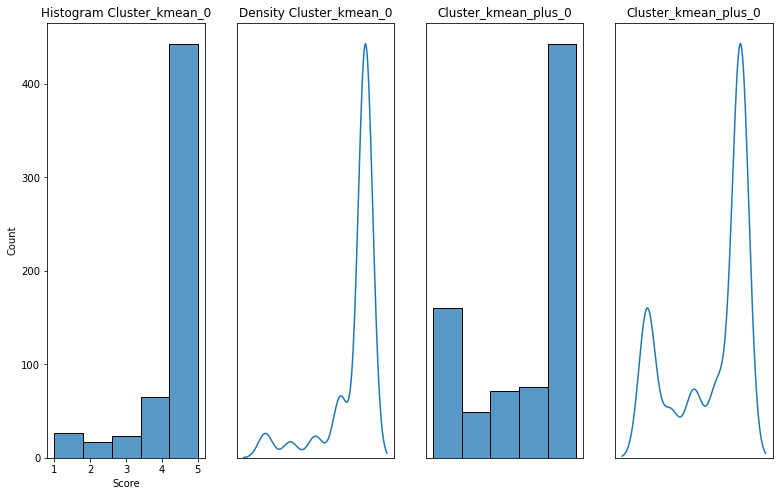

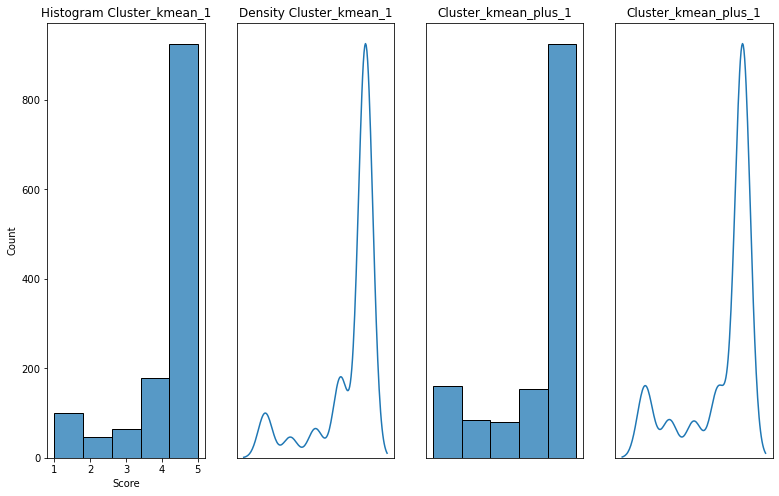

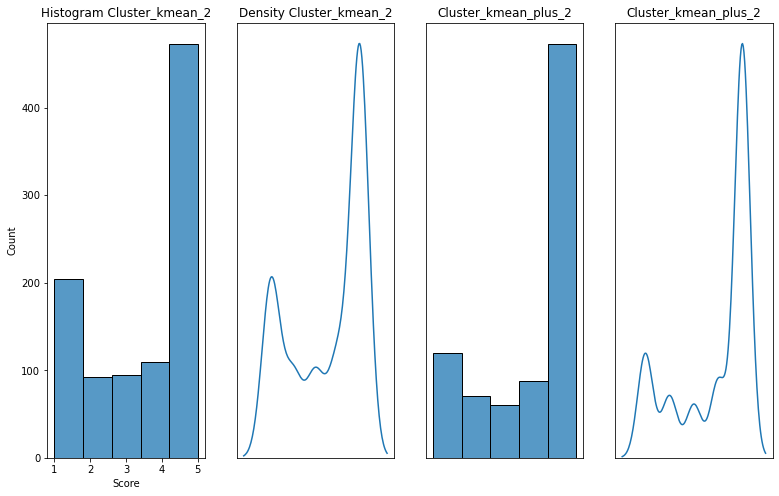

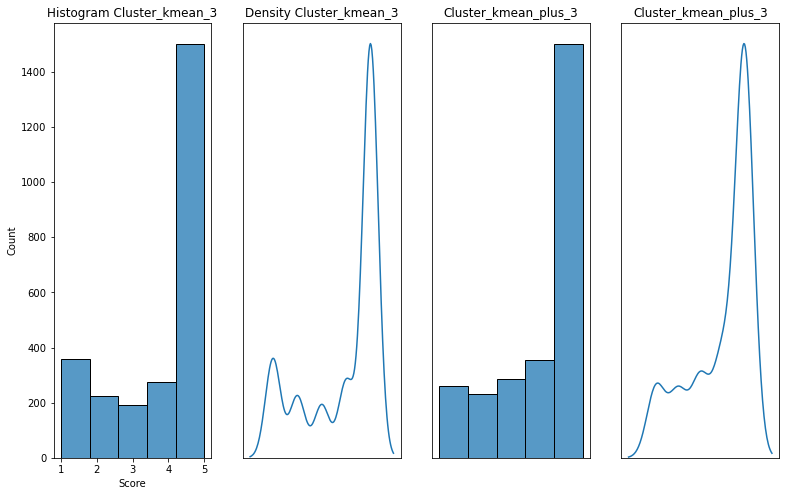

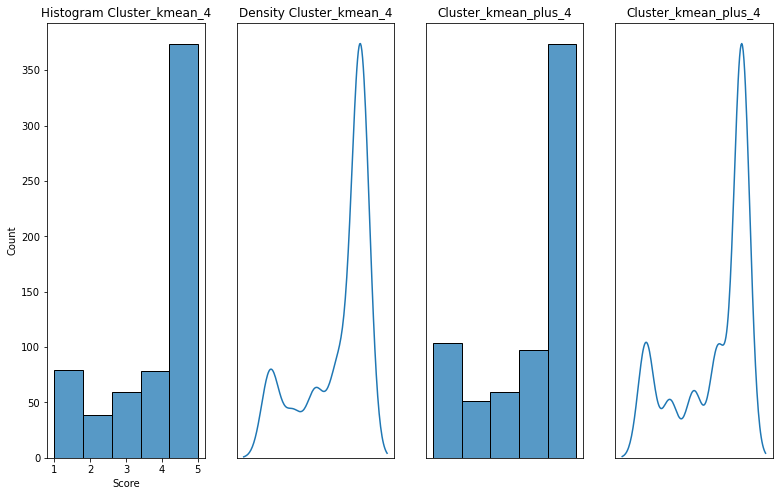

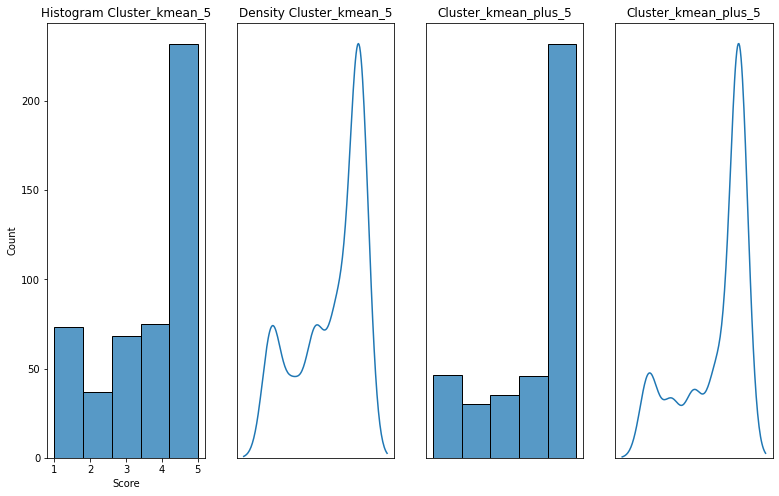

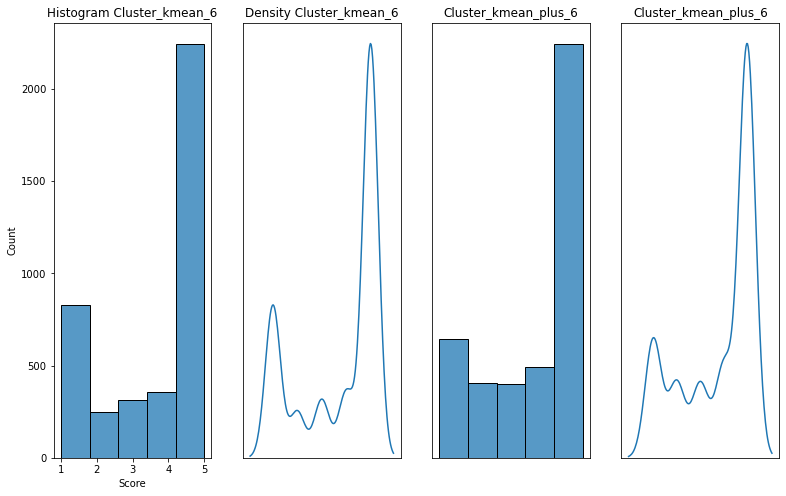

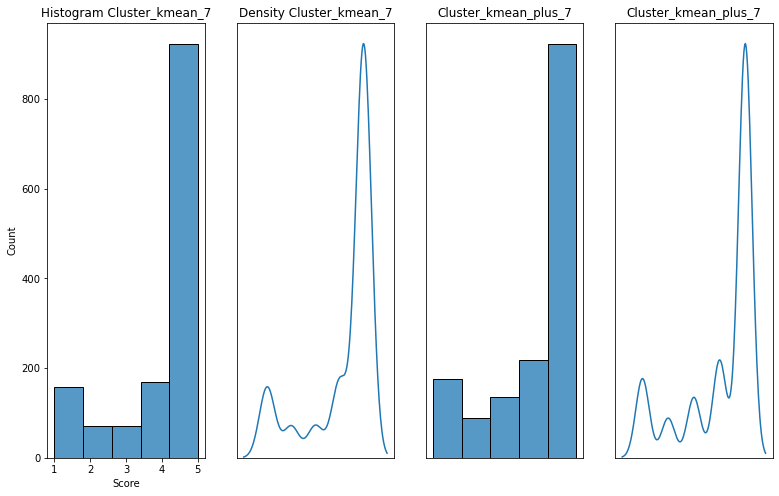

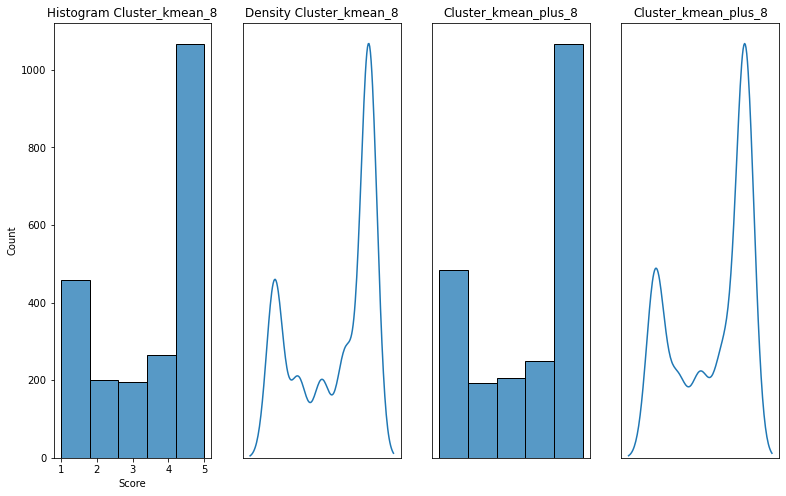

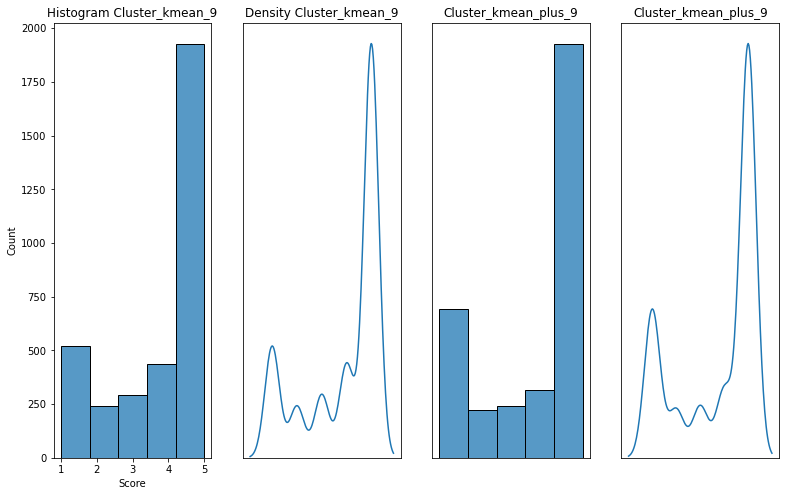

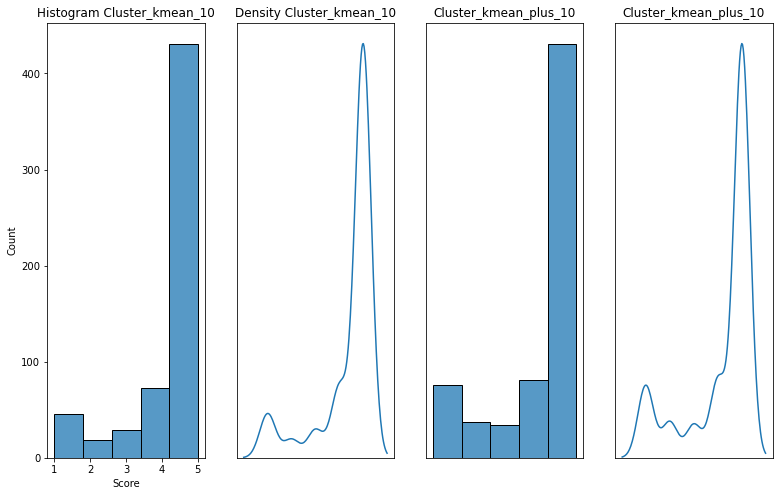

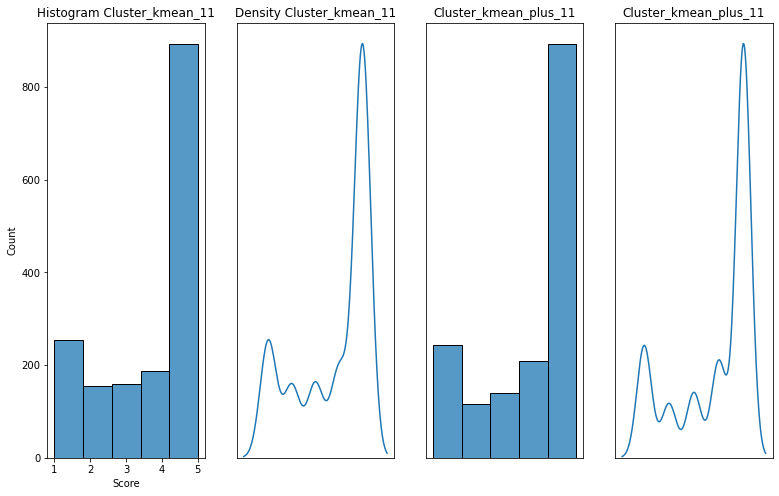

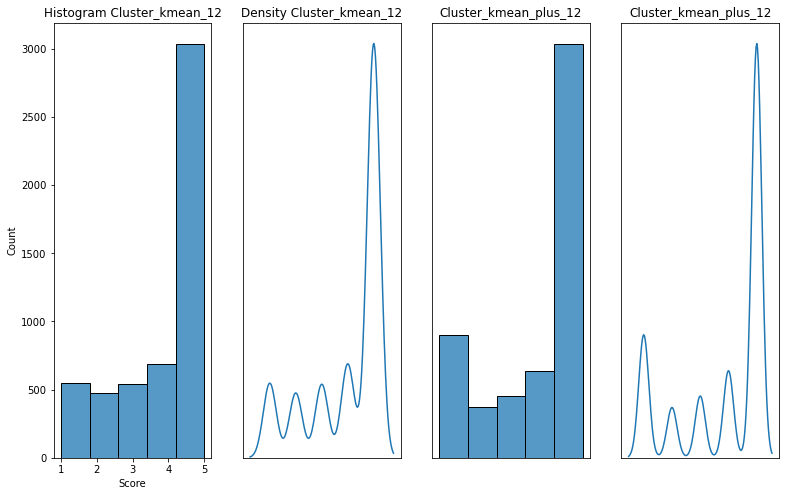

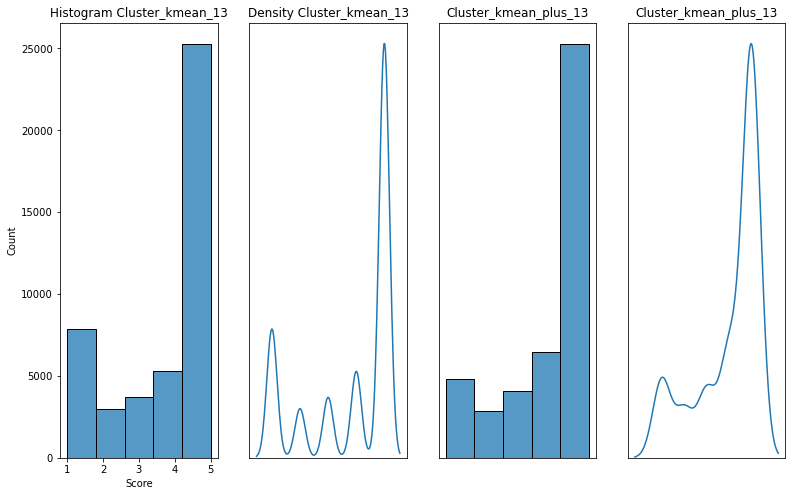

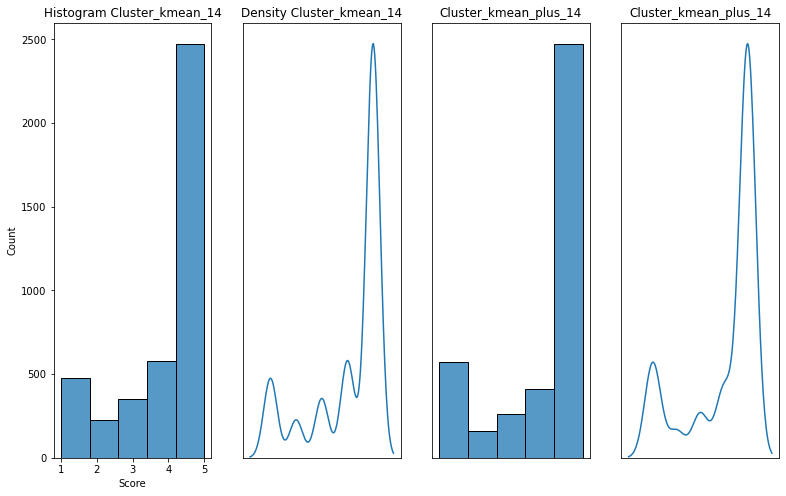

In [47]:
# Set the parameter
n_cluster = 15
selected_column_kmean = 'cluster_kmeans'
selected_column_kmean_plus = 'cluster_kmeans_plus'
column = 'Score'

# Plot the bins and distribution for each cluster
for i in range(n_cluster):
    exec(f'rate_cluster_kmean_{i} = df3[df3[selected_column_kmean] == {i}]')
    exec(f'rate_cluster_kmean_plus_{i} = df3[df3[selected_column_kmean_plus] == {i}]')
    fig, axes = plt.subplots(1, 4, figsize=(13,8))
    
    exec(f'sns.histplot(ax=axes[0], data = rate_cluster_kmean_{i}[column], bins=5)')
    axes[0].set_title(f'Histogram Cluster_kmean_{i}')
    
    exec(f'sns.kdeplot(ax=axes[1], data = rate_cluster_kmean_{i}[column]), plt.xlabel(column)')
    axes[1].set_title(f'Density Cluster_kmean_{i}')
    axes[1].xaxis.set_visible(False)
    axes[1].yaxis.set_visible(False)
    
    exec(f'sns.histplot(ax=axes[2], data = rate_cluster_kmean_plus_{i}[column], bins=5)')
    axes[2].set_title(f'Cluster_kmean_plus_{i}')
    axes[2].xaxis.set_visible(False)
    axes[2].yaxis.set_visible(False)
    
    exec(f'sns.kdeplot(ax=axes[3], data = rate_cluster_kmean_plus_{i}[column]), plt.xlabel(column)')
    axes[3].set_title(f'Cluster_kmean_plus_{i}')
    axes[3].xaxis.set_visible(False)
    axes[3].yaxis.set_visible(False)

The plots show us that in general the Score's distribution are very similar in each cluster, regardless the algorithm that we have used. However, there are some differences among different plots. This is because the density of each plot depends on the number of rate in each bins and these depends on the kind of cluster model used. All the plots present a peak on the best score (5) and some of them have another peak on the worst rate (1). 

Finally, we can note that each density is a Gaussian Mixture Model. In fact, the density seems behave like more Gaussians side by side.

- **Number of unique users writing reviews in each cluster**

In [48]:
# K-means
unique_prod_per_cluster={}
for cluster in range(0,n_cluster):
    unique_prod_per_cluster[cluster] = len(df3[df3.cluster_kmeans == cluster].UserId.unique())
unique_prod_per_cluster

{0: 502,
 1: 1131,
 2: 847,
 3: 2211,
 4: 574,
 5: 427,
 6: 3049,
 7: 1276,
 8: 1844,
 9: 2881,
 10: 573,
 11: 1493,
 12: 4451,
 13: 35809,
 14: 3285}

In [50]:
# K-means ++
unique_prod_per_cluster={}
for cluster in range(0,n_cluster):
    unique_prod_per_cluster[cluster] = len(df3[df3.cluster_kmeans_plus == cluster].UserId.unique())
unique_prod_per_cluster

{0: 1427,
 1: 1566,
 2: 2134,
 3: 358,
 4: 1695,
 5: 573,
 6: 1445,
 7: 3342,
 8: 963,
 9: 2391,
 10: 1294,
 11: 2919,
 12: 37830,
 13: 465,
 14: 1386}

This results tell us that the number of unique users follow the different ways to cluster the items according to the two types of algorithms. Hence, the number of unique users writing reviews changes according to the number of products in each cluster, which is a consequence of difference between k-means and k-means++ model. 